In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Import some additional JAX and dataloader helpers
from jax.scipy.special import logsumexp
from jax.experimental import optimizers

import torch
from torchvision import datasets, transforms
import mediapy as mpy
import time
from tqdm.auto import tqdm


import numpy as onp
import jax.numpy as np
from jax import grad, jit, vmap, value_and_grad
from jax import random


/Users/thomassajot/opt/anaconda3/envs/Attention/lib/python3.9/site-packages/jax/experimental/optimizers.py:28: FutureWarning: jax.experimental.optimizers is deprecated, import jax.example_libraries.optimizers instead
  warnings.warn('jax.experimental.optimizers is deprecated, '


In [ ]:
def plot_mnist_examples(dataloader, n=10):
    images, labels = next(iter(dataloader))
    images = images.squeeze()
    images = images[:n]
    labels = labels[:n].detach().numpy().astype(str)
    return mpy.show_images(images.squeeze(), titles=labels, columns=10, width=700)


def ReLU(x):
    """ Rectified Linear Unit (ReLU) activation function """
    return np.maximum(0, x)

def relu_layer(params, x):
    """ Simple ReLu layer for single sample """
    return ReLU(np.dot(params[0], x) + params[1])

In [2]:
# Generate key which is used to generate random numbers
key = random.PRNGKey(1)

In [114]:
batch_size = 100

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=batch_size, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=batch_size, shuffle=True)


plot_mnist_examples(train_loader)

3,5,2,9,3,8,7,5,6,1


In [115]:
def initialize_mlp(sizes, key):
    """ Initialize the weights of all layers of a linear layer network """
    keys = random.split(key, len(sizes))
    # Initialize a single layer with Gaussian weights -  helper function
    def initialize_layer(m, n, key, scale=1e-2):
        w_key, b_key = random.split(key)
        return scale * random.normal(w_key, (n, m)), scale * random.normal(b_key, (n,))
    return [initialize_layer(m, n, k) for m, n, k in zip(sizes[:-1], sizes[1:], keys)]

layer_sizes = [784, 512, 512, 10]
# Return a list of tuples of layer weights
params = initialize_mlp(layer_sizes, key)

In [116]:
def forward_pass(params, in_array):
    """ Compute the forward pass for each example individually """
    activations = in_array

    # Loop over the ReLU hidden layers
    for w, b in params[:-1]:
        activations = relu_layer([w, b], activations)

    # Perform final trafo to logits
    final_w, final_b = params[-1]
    logits = np.dot(final_w, activations) + final_b
    return logits - logsumexp(logits)

# Make a batched version of the `predict` function
batch_forward = vmap(forward_pass, in_axes=(None, 0), out_axes=0)

In [117]:
def _one_hot(x, k):
    """Create a one-hot encoding of x of size k """
    return np.eye(k)[x]

one_hot = jit(_one_hot, static_argnums=1)

def loss(params, in_arrays, targets):
    """ Compute the multi-class cross-entropy loss """
    preds = batch_forward(params, in_arrays)
    return -np.sum(preds * targets)

def accuracy(params, data_loader):
    """ Compute the accuracy for a provided dataloader """
    acc_total = 0
    for batch_idx, (data, target) in enumerate(data_loader):
        images = np.array(data).reshape(data.size(0), 28*28)
        targets = one_hot(np.array(target), num_classes)

        target_class = np.argmax(targets, axis=1)
        predicted_class = np.argmax(batch_forward(params, images), axis=1)
        acc_total += np.sum(predicted_class == target_class)
    return acc_total / len(data_loader.dataset)

In [118]:
@jit
def update(params, x, y, opt_state):
    """ Compute the gradient for a batch and update the parameters """
    value, grads = value_and_grad(loss)(params, x, y)
    opt_state = opt_update(0, grads, opt_state)
    return get_params(opt_state), opt_state, value

# Defining an optimizer in Jax
step_size = 1e-3
opt_init, opt_update, get_params = optimizers.adam(step_size)
opt_state = opt_init(params)

num_epochs = 5
num_classes = 10

In [119]:
def run_mnist_training_loop(num_epochs, opt_state, net_type="MLP"):
    """ Implements a learning loop over epochs. """
    # Initialize placeholder for loggin
    log_acc_train, log_acc_test, train_loss = [], [], []

    # Get the initial set of parameters
    params = get_params(opt_state)

    # Get initial accuracy after random init
    train_acc = accuracy(params, train_loader)
    test_acc = accuracy(params, test_loader)
    log_acc_train.append(train_acc)
    log_acc_test.append(test_acc)

    # Loop over the training epochs
    for epoch in tqdm(range(num_epochs)):
        start_time = time.time()
        for data, target in tqdm(train_loader, total=len(train_loader)):
            if net_type == "MLP":
                # Flatten the image into 784 vectors for the MLP
                x = np.array(data).reshape(data.size(0), 28*28)
            elif net_type == "CNN":
                # No flattening of the input required for the CNN
                x = np.array(data)
            y = one_hot(np.array(target), num_classes)
            params, opt_state, loss = update(params, x, y, opt_state)
            train_loss.append(loss)

        epoch_time = time.time() - start_time
        train_acc = accuracy(params, train_loader)
        test_acc = accuracy(params, test_loader)
        log_acc_train.append(train_acc)
        log_acc_test.append(test_acc)
        print(f"Epoch {epoch+1} | T: {epoch_time:0.2f} | Train A: {train_acc:0.3f} | Test A: {test_acc:0.3f}")

    return train_loss, log_acc_train, log_acc_test


train_loss, train_log, test_log = run_mnist_training_loop(num_epochs,
                                                          opt_state,
                                                          net_type="MLP")


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

Epoch 1 | T: 11.99 | Train A: 0.972 | Test A: 0.966


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch 2 | T: 11.55 | Train A: 0.986 | Test A: 0.976


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch 3 | T: 11.82 | Train A: 0.989 | Test A: 0.976


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch 4 | T: 11.65 | Train A: 0.992 | Test A: 0.978


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch 5 | T: 11.54 | Train A: 0.994 | Test A: 0.979


NameError: name 'plot_mnist_performance' is not defined

In [125]:
train_log

[DeviceArray(0.11236667, dtype=float32),
 DeviceArray(0.9722833, dtype=float32),
 DeviceArray(0.9859167, dtype=float32),
 DeviceArray(0.98943335, dtype=float32),
 DeviceArray(0.99186665, dtype=float32),
 DeviceArray(0.9945, dtype=float32)]

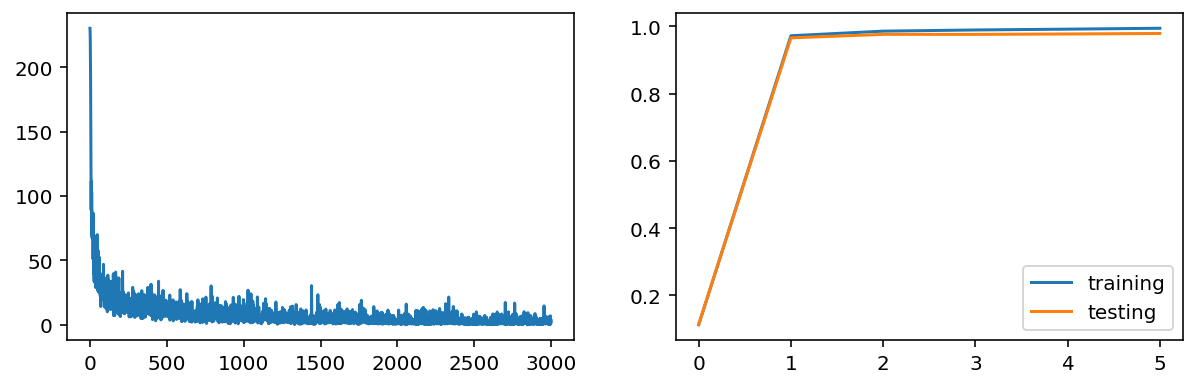

In [141]:
import matplotlib.pyplot as plt

_, axes = plt.subplots(1, 2, figsize=(10, 3))
axes[0].plot(onp.array(train_loss))
axes[1].plot(onp.array(train_log), label='training')
axes[1].plot(onp.array(test_log), label='testing')
axes[1].legend()
plt.show()